# Streaming Platform Twitter Trends in the Covid-19 Pandemic

## Data Load and Preparation

<b>Filename:</b> Streaming_Happiness_Project.ipynb<br>
<b>Date Created:</b> March 2, 2021<br>
<b>Last Updated:</b> March 20, 2021<br>
<b>Created By:</b> Jennifer Han and Christina DaSilva<br>
<b>Purpose:</b> Read in Twitter data on streaming platforms and World Happiness Report data and perform analyses<br>

### Package Install and Import Statements

In [2]:
#!pip install twint #Only needed for retreiving tweets (already done)

In [3]:
#!pip install WordCloud #Run, if necessary

In [4]:
import pandas as pd
#import twint #Only needed for retreiving tweets (already done)
import json
import csv
import nltk
import re
import seaborn as sea
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

### File Access

In [5]:
# THIS IS ONLY REQUIRED WHEN LOADING IN COLAB
# Mount Google Drive for file access
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
# # THIS IS ONLY REQUIRED WHEN LOADING IN COLAB
# Change directory to shared project folder
# %cd /content/drive/MyDrive/IST652_Final_Project

/content/drive/.shortcut-targets-by-id/1uHFNLuM2WRelgZSY8a1DwH3DDjseXPAe/IST652_Final_Project


### Load World Happiness Report Data

In [7]:
###############################
# WORLD HAPPINESS REPORT DATA #
###############################
# Read in World Happiness Report data from csv
happiness_filename = '2020_world_happiness_report.csv'

happiness_df = pd.read_csv(happiness_filename)

# Print out some information about the data read in
print('Successfully read in data from:', happiness_filename, '\n')
print('Happiness Dataframe Shape: {row} rows and {col} columns'.format(row = happiness_df.shape[0], col = happiness_df.shape[1]), '\n')
print('First 10 rows Happiness Dataframe:\n', happiness_df.head(10), '\n')




Successfully read in data from: 2020_world_happiness_report.csv 

Happiness Dataframe Shape: 153 rows and 20 columns 

First 10 rows Happiness Dataframe:
   Country name  ... Dystopia + residual
0      Finland  ...            2.762835
1      Denmark  ...            2.432741
2  Switzerland  ...            2.350267
3      Iceland  ...            2.460688
4       Norway  ...            2.168266
5  Netherlands  ...            2.352117
6       Sweden  ...            2.246299
7  New Zealand  ...            2.128108
8      Austria  ...            2.398446
9   Luxembourg  ...            2.153700

[10 rows x 20 columns] 



### Load World Cities Data

In [8]:
#####################
# WORLD CITIES DATA #
#####################
# Read in World Cities data and store in a dataframe
# The worldcities.csv file is sorted from largest population cities to smallest
# Website source: https://simplemaps.com/data/world-cities

world_cities_file = 'worldcities.csv'
world_cities_df = pd.read_csv(world_cities_file)

print('First 10 rows World Cities Dataframe: ', world_cities_df.head(10), '\n')

# Get only the rows of the dataset that are the capital cities 
# According to the data dictionary for the dataset (see website), where capital column = "primary")
capitals_df = world_cities_df[world_cities_df['capital'] == 'primary']

# Drop duplicates to clean up the data. Some countries have more than 1 primary capital listed in this dataset
capitals_df.drop_duplicates(subset = 'country', inplace = True)

print('First 10 rows Capitals Dataframe:\n', capitals_df.head(10), '\n')
print('Capitals Dataframe Shape: ', capitals_df.shape, '\n')

First 10 rows World Cities Dataframe:            city   city_ascii      lat  ...  capital  population          id
0        Tokyo        Tokyo  35.6897  ...  primary  37977000.0  1392685764
1      Jakarta      Jakarta  -6.2146  ...  primary  34540000.0  1360771077
2        Delhi        Delhi  28.6600  ...    admin  29617000.0  1356872604
3       Mumbai       Mumbai  18.9667  ...    admin  23355000.0  1356226629
4       Manila       Manila  14.5958  ...  primary  23088000.0  1608618140
5     Shanghai     Shanghai  31.1667  ...    admin  22120000.0  1156073548
6    São Paulo    Sao Paulo -23.5504  ...    admin  22046000.0  1076532519
7        Seoul        Seoul  37.5833  ...  primary  21794000.0  1410836482
8  Mexico City  Mexico City  19.4333  ...  primary  20996000.0  1484247881
9    Guangzhou    Guangzhou  23.1288  ...    admin  20902000.0  1156237133

[10 rows x 11 columns] 

First 10 rows Capitals Dataframe:
             city    city_ascii      lat  ...  capital  population          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Join Capitals and World Happiness Report Data

In [9]:
# Join together the happiness df and the capitals df on the country field

# Use a left join to check for spelling discrepancies
happiness_capitals_df = happiness_df.merge(capitals_df, how = 'left', left_on = 'Country name', right_on = 'country')
print('First 10 rows Happiness Capitals Dataframe:\n', happiness_capitals_df.head(10), '\n')

print('Happiness Capitals Dataframe Shape: ', happiness_capitals_df.shape, '\n')

# Data cleaning for country names that are spelled differently
# Find the rows with NaN due to the left join and the country names not matching precisely
cities_with_NAN_df = happiness_capitals_df[happiness_capitals_df['city_ascii'].isna()]
print('Cities with NAN due to left join: \n', cities_with_NAN_df[['Country name', 'city_ascii']], '\n')

# Create a dictionary with the happiness dataset country name mapped to the capitals dataset country names
# Any country with 'None' denoted means that there are no cities in that country where the capital field = primary
# Thus, we need to remove that row from the happiness_df before doing the left join
country_name_mapping = {
	'Canada': 'None',
	'Czech Republic':'Czechia',
	'Taiwan Province of China': 'Taiwan',
	'Trinidad and Tobago': 'Trinidad And Tobago',
	'South Korea': 'Korea, South',
	'Bosnia and Herzegovina': 'Bosnia And Herzegovina',
	'North Cyprus': 'None',
	'Hong Kong S.A.R. of China': 'None',
	'Ivory Coast': 'None',
	'Gambia': 'Gambia, The',
	'Palestinian Territories': 'None',
	'Myanmar': 'None'
	}


# Clean up the happiness_df and the capitals_df for the left join on country name to remove all NaN values
# Replace the country field in the capitals dataframe with the new values
capitals_clean_df = capitals_df
for key in country_name_mapping:
	capitals_clean_df = capitals_clean_df.replace(country_name_mapping[key], key)

# Drop rows of the happiness dataframe for cities where there are no cities with capital = primary according to the World Cities dataset
happiness_clean_df = happiness_df
indexes_to_drop = []
for key in country_name_mapping:
	if country_name_mapping[key] == 'None':
		happiness_clean_df = happiness_clean_df.drop(happiness_clean_df[ happiness_clean_df['Country name'] == key].index)


# Create a new left join merge of the cleaned up happiness_clean_df and the capitals_clean_df
happiness_capitals_clean_df = happiness_clean_df.merge(capitals_clean_df, how = 'left', left_on = 'Country name', right_on = 'country')

# Sort the dataframe with the largest population capitals first
happiness_capitals_clean_df = happiness_capitals_clean_df.sort_values(by=['population'], ascending = False)
print('First 10 rows Happiness Capitals Clean Dataframe:\n', happiness_capitals_clean_df.head(10), '\n')

# Check to ensure that the new left join with clean data is returning no NaN values, which means every left join from the happiness dataset was successful
print('Post Data Cleansing -- Cities with NaN values due to left join:', len(happiness_capitals_clean_df[happiness_capitals_clean_df['city_ascii'].isna()]), '\n')

# Get the top 50 rows
top50_happiness_capitals_clean_df = happiness_capitals_clean_df[0:50]

First 10 rows Happiness Capitals Dataframe:
   Country name     Regional indicator  ...  population            id
0      Finland         Western Europe  ...    642045.0  1.246178e+09
1      Denmark         Western Europe  ...   1085000.0  1.208764e+09
2  Switzerland         Western Europe  ...    133798.0  1.756374e+09
3      Iceland         Western Europe  ...    128793.0  1.352327e+09
4       Norway         Western Europe  ...    693494.0  1.578325e+09
5  Netherlands         Western Europe  ...   1406000.0  1.528800e+09
6       Sweden         Western Europe  ...    972647.0  1.752426e+09
7  New Zealand  North America and ANZ  ...    418500.0  1.554772e+09
8      Austria         Western Europe  ...   1840573.0  1.040262e+09
9   Luxembourg         Western Europe  ...    122273.0  1.442263e+09

[10 rows x 31 columns] 

Happiness Capitals Dataframe Shape:  (153, 31) 

Cities with NAN due to left join: 
                   Country name city_ascii
10                      Canada        NaN
1

### Load US Cities Data

In [10]:
##################
# US CITIES DATA #
##################
# Read in US Cities data and store in a dataframe
# The uscities.csv file is sorted from largest population cities to smallest
# Website source: https://simplemaps.com/data/us-cities

us_cities_file = 'uscities.csv'
us_cities_df = pd.read_csv(us_cities_file)

# Sort the dataframe with the largest population US cities first
us_cities_df = us_cities_df.sort_values(by=['population'], ascending = False)

# Get just the top 50 rows
top50_us_cities_df = us_cities_df[0:50]

print('First 10 rows US Cities Dataframe: ', top50_us_cities_df.head(10), '\n')



First 10 rows US Cities Dataframe:             city  ...          id
0      New York  ...  1840034016
1   Los Angeles  ...  1840020491
2       Chicago  ...  1840000494
3         Miami  ...  1840015149
4        Dallas  ...  1840019440
5  Philadelphia  ...  1840000673
6       Houston  ...  1840020925
7       Atlanta  ...  1840013660
8    Washington  ...  1840006060
9        Boston  ...  1840000455

[10 rows x 17 columns] 



Set Up Twitter Scraping Functions

In [11]:
# Create a function that scrapes data per city using twint
def scrape_tweets_by_city(lat, long, radius, output_filename, search_term, since_date, until_date):
	c = twint.Config()
	c.Search = search_term
	c.Output = output_filename
	c.Geo = '{lat},{long},{radius}km'.format(lat = lat, long = long, radius = radius)
	c.Since = since_date
	c.Until = until_date
	c.Count = True
	c.Store_json = True
	twint.run.Search(c)


# Create csv output filenames
world_netflix_output_filename = 'world_tweets_netflix.json'
world_prime_output_filename = 'world_tweets_prime.json'
world_hulu_output_filename = 'world_tweets_hulu.json'

us_netflix_output_filename = 'us_tweets_netflix.json'
us_prime_output_filename = 'us_tweets_prime.json'
us_hulu_output_filename = 'us_tweets_hulu.json'


# Set date range for Jan - Dec 2020
since_date = '2020-01-01'
until_date = '2020-12-31'


# Set radius
city_radius = 10

### Scrape Twitter Data 

#### (Already run - do not need to run again)



In [12]:
# Note: Due to the long time runtime for this code, it is commented out as it has already been run

######################################
# SCRAPE WORLD CAPITALS TWITTER DATA #
######################################

# Scrape tweets that mention the 3 streaming platforms for top 50 world capital cities by population
# Note: This will take some time to run and complete. 

######### COMMENTED OUT SO THIS DOESN'T RE-RUN!!!!!!!
"""
print('Scraping tweets in 2020 for world capitals...')

for index, row in top50_happiness_capitals_clean_df.iterrows():
	print('Scraping Tweets from: ', row['city'], '\n')
	scrape_tweets_by_city(row['lat'], row['lng'], city_radius, world_netflix_output_filename, 'netflix', since_date, until_date)
	scrape_tweets_by_city(row['lat'], row['lng'], city_radius, world_prime_output_filename, '\"primevideo\"', since_date, until_date)
	scrape_tweets_by_city(row['lat'], row['lng'], city_radius, world_prime_output_filename, '\"prime video\"', since_date, until_date)
	scrape_tweets_by_city(row['lat'], row['lng'], city_radius, world_hulu_output_filename, 'hulu', since_date, until_date)
"""



#################################
# SCRAPE US CITIES TWITTER DATA #
#################################

# Scrape tweets that mention the 3 streaming platforms for top 50 US cities by population
# Note: This will take some time to run and complete. 


######### COMMENTED OUT SO THIS DOESN'T RE-RUN!!!!!!!
"""
print('Scraping tweets in 2020 for US capitals...')

for index, row in top50_us_cities_df.iterrows():
	print('Scraping Tweets from: ', row['city'], '\n')
	scrape_tweets_by_city(row['lat'], row['lng'], city_radius, us_netflix_output_filename, 'netflix', since_date, until_date)
	scrape_tweets_by_city(row['lat'], row['lng'], city_radius, us_prime_output_filename, '\"primevideo\"', since_date, until_date)
	scrape_tweets_by_city(row['lat'], row['lng'], city_radius, us_prime_output_filename, '\"prime video\"', since_date, until_date)
	scrape_tweets_by_city(row['lat'], row['lng'], city_radius, us_hulu_output_filename, 'hulu', since_date, until_date)
"""

'\nprint(\'Scraping tweets in 2020 for US capitals...\')\n\nfor index, row in top50_us_cities_df.iterrows():\n\tprint(\'Scraping Tweets from: \', row[\'city\'], \'\n\')\n\tscrape_tweets_by_city(row[\'lat\'], row[\'lng\'], city_radius, us_netflix_output_filename, \'netflix\', since_date, until_date)\n\tscrape_tweets_by_city(row[\'lat\'], row[\'lng\'], city_radius, us_prime_output_filename, \'"primevideo"\', since_date, until_date)\n\tscrape_tweets_by_city(row[\'lat\'], row[\'lng\'], city_radius, us_prime_output_filename, \'"prime video"\', since_date, until_date)\n\tscrape_tweets_by_city(row[\'lat\'], row[\'lng\'], city_radius, us_hulu_output_filename, \'hulu\', since_date, until_date)\n'

### Read In, Store, Clean Twitter Data from JSON Files

#### *World Capitals Twitter Data*



In [13]:
# WORLD CAPITALS TWITTER DATA
# Read in the 3 json files of tweet data and convert to pandas dataframes
# Insert a new column for the streaming platform name. This will be used when we append the 3 dataframes into 1 dataframe.
world_netflix_df = pd.read_json(world_netflix_output_filename, lines = True)
world_netflix_df.insert(0, 'platform', 'Netflix')
print('World Netflix Dataframe Created: \n', world_netflix_df.head(10), '\n')
print('World Netflix Dataframe Shape: \n', world_netflix_df.shape, '\n')

world_prime_df = pd.read_json(world_prime_output_filename, lines = True)
world_prime_df.insert(0, 'platform', 'Amazon Prime')
print('World Amazon Prime Dataframe Created: \n', world_prime_df.head(10), '\n')
print('World Amazon Prime Dataframe Shape: \n', world_prime_df.shape, '\n')

world_hulu_df = pd.read_json(world_hulu_output_filename, lines = True)
world_hulu_df.insert(0, 'platform', 'Hulu')
print('World Hulu Dataframe Created: \n', world_hulu_df.head(10), '\n')
print('World Hulu Dataframe Shape: \n', world_hulu_df.shape, '\n')

# Append the dataframes to create 1 dataframe for world capitals tweets 
world_tweets_all_platforms_df = world_netflix_df.append(world_prime_df).append(world_hulu_df)
print('World All Platforms Dataframe Created: \n', world_tweets_all_platforms_df.head(10), '\n')
print('World All Platforms Dataframe Shape: \n', world_tweets_all_platforms_df.shape, '\n')

# Insert 2 new columns for the lat and lng columns extracted from the geo column
world_tweets_all_platforms_df.insert(1, 'lat', 'Not assigned')
world_tweets_all_platforms_df.insert(2, 'lng', 'Not assigned')

# Create 2 functions that parse the geo column and returns the lat, long values
def extract_lat(row):
	geolocation = row['geo'].split(',')
	return float(geolocation[0])

def extract_long(row):
	geolocation = row['geo'].split(',')
	return float(geolocation[1])
 
# Use .apply() function to assign the lat and lng columns from the geo column for all rows of the dataframe
world_tweets_all_platforms_df['lat'] = world_tweets_all_platforms_df.apply(lambda row: extract_lat(row), axis=1)
world_tweets_all_platforms_df['lng'] = world_tweets_all_platforms_df.apply(lambda row: extract_long(row), axis=1)

print('World All Platforms Dataframe lat, lng columns added: \n', world_tweets_all_platforms_df.head(10), '\n')

# Left join world_tweets_all_platforms_df with the city_ascii and country columns from top50_happiness_capitals_clean_df on the lat and lng columns
print('Finding matching city and country for World Tweets Dataframe...')
world_tweets_all_platforms_df = world_tweets_all_platforms_df.merge(top50_happiness_capitals_clean_df[['city_ascii', 'country', 'lat', 'lng']], how='left', left_on=['lat', 'lng'], right_on=['lat','lng'])
print('World All Platforms Dataframe matched city and country columns: \n', world_tweets_all_platforms_df.head(10), '\n')
print('World All Platforms Dataframe Shape: \n', world_tweets_all_platforms_df.shape, '\n')

# Drop the extraneous lat and lng columns now that we have the city and country columns added. We only needed them to perform the left join
world_tweets_all_platforms_df = world_tweets_all_platforms_df.drop(['lat', 'lng'], axis = 1)
print('World All Platforms Dataframe dropped lat lng columns: \n', world_tweets_all_platforms_df.head(10), '\n')

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


World Netflix Dataframe Created: 
   platform                   id  ...  trans_src trans_dest
0  Netflix  1343948213116551170  ...                      
1  Netflix  1343917356456636417  ...                      
2  Netflix  1343901145345900545  ...                      
3  Netflix  1343889948944945153  ...                      
4  Netflix  1343888922447777792  ...                      
5  Netflix  1343878569622028288  ...                      
6  Netflix  1343872556391022595  ...                      
7  Netflix  1343862001785663488  ...                      
8  Netflix  1343831708936761344  ...                      
9  Netflix  1343808973095366658  ...                      

[10 rows x 37 columns] 

World Netflix Dataframe Shape: 
 (42530, 37) 



/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


World Amazon Prime Dataframe Created: 
        platform                   id  ...  trans_src trans_dest
0  Amazon Prime  1343862001785663488  ...                      
1  Amazon Prime  1342480833060356097  ...                      
2  Amazon Prime  1342038474321317890  ...                      
3  Amazon Prime  1336956907165081603  ...                      
4  Amazon Prime  1251153879862964226  ...                      
5  Amazon Prime  1249331709209796608  ...                      
6  Amazon Prime  1247491816061952000  ...                      
7  Amazon Prime  1247228547812323329  ...                      
8  Amazon Prime  1246352987611484162  ...                      
9  Amazon Prime  1343882324828594176  ...                      

[10 rows x 37 columns] 

World Amazon Prime Dataframe Shape: 
 (1220, 37) 



/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


World Hulu Dataframe Created: 
   platform                   id  ...  trans_src trans_dest
0     Hulu  1344069452988497920  ...                      
1     Hulu  1343855550795149312  ...                      
2     Hulu  1343586630339239943  ...                      
3     Hulu  1343405622478290944  ...                      
4     Hulu  1342779346080034816  ...                      
5     Hulu  1342480520542883840  ...                      
6     Hulu  1342383147850158080  ...                      
7     Hulu  1341974560292233217  ...                      
8     Hulu  1340570141906489345  ...                      
9     Hulu  1340568764262170625  ...                      

[10 rows x 37 columns] 

World Hulu Dataframe Shape: 
 (1575, 37) 

World All Platforms Dataframe Created: 
   platform                   id  ...  trans_src trans_dest
0  Netflix  1343948213116551170  ...                      
1  Netflix  1343917356456636417  ...                      
2  Netflix  1343901145345900545 

#### US Cities Twitter Data



In [14]:
# US CITIES TWITTER DATA
# Read in the 3 json files of tweet data and convert to pandas dataframes
# Insert a new column for the streaming platform name. This will be used when we append the 3 dataframes into 1 dataframe.
us_netflix_df = pd.read_json(us_netflix_output_filename, lines = True)
us_netflix_df.insert(0, 'platform', 'Netflix')
print('US Netflix Dataframe Created: \n', us_netflix_df.head(10), '\n')
print('US Netflix Dataframe Shape: \n', us_netflix_df.shape, '\n')

us_prime_df = pd.read_json(us_prime_output_filename, lines = True)
us_prime_df.insert(0, 'platform', 'Amazon Prime')
print('US Amazon Prime Dataframe Created: \n', us_prime_df.head(10), '\n')
print('US Amazon Prime Dataframe Shape: \n', us_prime_df.shape, '\n')

us_hulu_df = pd.read_json(us_hulu_output_filename, lines = True)
us_hulu_df.insert(0, 'platform', 'Hulu')
print('US Hulu Dataframe Created: \n', us_hulu_df.head(10), '\n')
print('US Hulu Dataframe Shape: \n', us_hulu_df.shape, '\n')

# Append the dataframes to create 1 dataframe for US cities tweets
us_tweets_all_platforms_df = us_netflix_df.append(us_prime_df).append(us_hulu_df)
print('US All Platforms Dataframe Created: \n', us_tweets_all_platforms_df.head(10), '\n')
print('US All Platforms Dataframe Shape: \n', us_tweets_all_platforms_df.shape, '\n')


# Insert 2 new columns for the lat and lng columns extracted from the geo column
us_tweets_all_platforms_df.insert(1, 'lat', 'Not assigned')
us_tweets_all_platforms_df.insert(2, 'lng', 'Not assigned')

# We will use the same 2 functions extract_lat and extract_long defined earlier to parse the geo column and return the lat, long values
# Use .apply() function to assign the lat and lng columns from the geo column for all rows of the dataframe
us_tweets_all_platforms_df['lat'] = us_tweets_all_platforms_df.apply(lambda row: extract_lat(row), axis=1)
us_tweets_all_platforms_df['lng'] = us_tweets_all_platforms_df.apply(lambda row: extract_long(row), axis=1)

print('US All Platforms Dataframe lat, lng columns added: \n', us_tweets_all_platforms_df.head(10), '\n')

# Left join us_tweets_all_platforms_df with the city_ascii column from top50_us_cities_df on the lat and lng columns
print('Finding matching city for US Tweets Dataframe...')
us_tweets_all_platforms_df = us_tweets_all_platforms_df.merge(top50_us_cities_df[['city_ascii', 'lat', 'lng']], how='left', left_on=['lat', 'lng'], right_on=['lat','lng'])
print('US All Platforms Dataframe matched city and country columns: \n', us_tweets_all_platforms_df.head(10), '\n')
print('US All Platforms Dataframe Shape: \n', us_tweets_all_platforms_df.shape, '\n')

# Drop the extraneous lat and lng columns now that we have the city columns added. We only needed them to perform the left join
us_tweets_all_platforms_df = us_tweets_all_platforms_df.drop(['lat', 'lng'], axis = 1)
print('US All Platforms Dataframe dropped lat lng columns: \n', us_tweets_all_platforms_df.head(10), '\n')


/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


US Netflix Dataframe Created: 
   platform                   id  ...  trans_src trans_dest
0  Netflix  1344070429900681218  ...                      
1  Netflix  1344068892763807744  ...                      
2  Netflix  1344068472494575617  ...                      
3  Netflix  1344053767814184962  ...                      
4  Netflix  1344048704400072709  ...                      
5  Netflix  1344048644660465664  ...                      
6  Netflix  1344033012737060865  ...                      
7  Netflix  1344029858993725440  ...                      
8  Netflix  1343996838387601408  ...                      
9  Netflix  1343989226413699074  ...                      

[10 rows x 37 columns] 

US Netflix Dataframe Shape: 
 (88549, 37) 



/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


US Amazon Prime Dataframe Created: 
        platform                   id  ...  trans_src trans_dest
0  Amazon Prime  1344059014989099010  ...                      
1  Amazon Prime  1344030839877881856  ...                      
2  Amazon Prime  1344019729388810241  ...                      
3  Amazon Prime  1343975344563499010  ...                      
4  Amazon Prime  1343973196614279168  ...                      
5  Amazon Prime  1343968652178182147  ...                      
6  Amazon Prime  1343559722432155648  ...                      
7  Amazon Prime  1343421521742737408  ...                      
8  Amazon Prime  1343200403207446528  ...                      
9  Amazon Prime  1342983601093275651  ...                      

[10 rows x 37 columns] 

US Amazon Prime Dataframe Shape: 
 (3701, 37) 



/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


US Hulu Dataframe Created: 
   platform                   id  ...  trans_src trans_dest
0     Hulu  1344068892763807744  ...                      
1     Hulu  1344048704400072709  ...                      
2     Hulu  1343951793525575681  ...                      
3     Hulu  1343797981166907393  ...                      
4     Hulu  1343786834921476097  ...                      
5     Hulu  1343760649273401344  ...                      
6     Hulu  1343714312616095745  ...                      
7     Hulu  1343659409206079489  ...                      
8     Hulu  1343611405375844352  ...                      
9     Hulu  1343559722432155648  ...                      

[10 rows x 37 columns] 

US Hulu Dataframe Shape: 
 (15043, 37) 

US All Platforms Dataframe Created: 
   platform                   id  ...  trans_src trans_dest
0  Netflix  1344070429900681218  ...                      
1  Netflix  1344068892763807744  ...                      
2  Netflix  1344068472494575617  ...    

These are the following dataframes to be used and manipulated for the analyses below

1. **top50_happiness_capitals_clean_df**:
The top 50 world capitals (based on population size) dataset joined with the associated happiness report dataset for that country.

2. **top50_us_cities_df**:
The top 50 US cities (based on population size) dataset

3. **world_tweets_all_platforms_df**:
Tweets from Jan 1 - Dec 31 2020 that had a geolocation in the top 50 world capitals that mention "netflix", "prime video" or "primevideo", and "hulu"

4. **us_tweets_all_platforms_df**:
Tweets from Jan 1 - Dec 31 2020 that had a geolocation in the top 50 US cities that mention "netflix", "prime video" or "primevideo", and "hulu"


In [15]:
world_tweets_all_platforms_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45325 entries, 0 to 45324
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   platform         45325 non-null  object        
 1   id               45325 non-null  int64         
 2   conversation_id  45325 non-null  int64         
 3   created_at       45325 non-null  datetime64[ns]
 4   date             45325 non-null  datetime64[ns]
 5   time             45325 non-null  object        
 6   timezone         45325 non-null  int64         
 7   user_id          45325 non-null  int64         
 8   username         45325 non-null  object        
 9   name             45325 non-null  object        
 10  place            45325 non-null  object        
 11  tweet            45325 non-null  object        
 12  language         45325 non-null  object        
 13  mentions         45325 non-null  object        
 14  urls             45325 non-null  objec

In [16]:
us_tweets_all_platforms_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107293 entries, 0 to 107292
Data columns (total 38 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   platform         107293 non-null  object        
 1   id               107293 non-null  int64         
 2   conversation_id  107293 non-null  int64         
 3   created_at       107293 non-null  datetime64[ns]
 4   date             107293 non-null  datetime64[ns]
 5   time             107293 non-null  object        
 6   timezone         107293 non-null  int64         
 7   user_id          107293 non-null  int64         
 8   username         107293 non-null  object        
 9   name             107293 non-null  object        
 10  place            107293 non-null  object        
 11  tweet            107293 non-null  object        
 12  language         107293 non-null  object        
 13  mentions         107293 non-null  object        
 14  urls             107

## Analysis

### ANALYSIS #1: World Demographic Trends on Tweets of Streaming Platforms

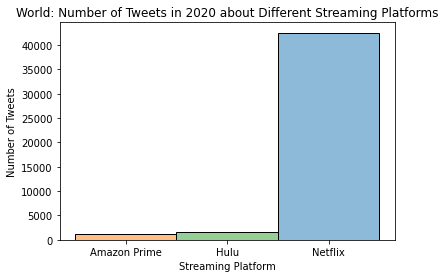

In [17]:
##########################################################################
# ANALYSIS #1: World demographic trends on Tweets of streaming platforms #
##########################################################################

# Hist plot of tweets by platform

# Aggregates world tweets by country, counting tweets, by platform, per country
w_platform_df = world_tweets_all_platforms_df.sort_values(by=['id'], ascending=True).groupby(['platform','country']).id.count()
w_platform_df.head(45)

a = sea.histplot(data=w_platform_df,x='platform', hue='platform')
a = sea.histplot(data=world_tweets_all_platforms_df,x='platform', hue='platform')
a.set(xlabel='Streaming Platform', ylabel='Number of Tweets', title='World: Number of Tweets in 2020 about Different Streaming Platforms')
a.legend_.remove()

In [36]:
# Top five countries with the most tweets, by each platform
w = world_tweets_all_platforms_df
w_agg = w.groupby(['platform', 'country']).count().reset_index()
#print(w_agg)

w_sorted = w_agg.groupby(['platform']).apply(lambda x: x.sort_values(['id'],ascending = False)).reset_index(drop = True)
#print(w_sorted)

x = w_sorted.groupby(['platform']).head(5).reset_index()
x.rename(columns = {'platform':'Platform','country':'Country','id':'Tweet Count'}, inplace = True)
x[['Platform','Country','Tweet Count']]

,Platform,Country,Tweet Count
0,Amazon Prime,United Kingdom,197
1,Amazon Prime,Chile,164
2,Amazon Prime,Spain,123
3,Amazon Prime,Mexico,112
4,Amazon Prime,Argentina,101
5,Hulu,Malaysia,860
6,Hulu,Indonesia,263
7,Hulu,Japan,144
8,Hulu,United States,98
9,Hulu,Spain,31


[Text(0, 0.5, 'Number of Tweets'),
 Text(0.5, 0, 'Streaming Platform'),
 Text(0.5, 1.0, 'Countries with Top Number of Tweets in 2020 about Different Streaming Platforms')]

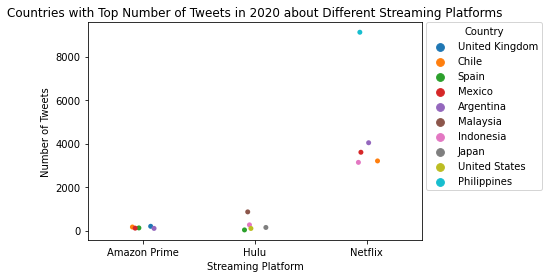

In [19]:
# Plot of Countries with Top Number of Tweets in 2020 about Different Streaming Platforms
b=sea.stripplot(data=x, x='platform', y='id', hue='country')
b.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0).set_title('Country') # move legend outside plot
b.set(xlabel='Streaming Platform', ylabel='Number of Tweets', title='Countries with Top Number of Tweets in 2020 about Different Streaming Platforms')

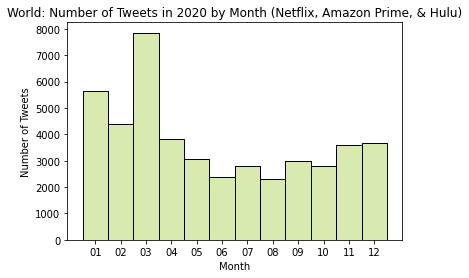

In [20]:
# Number of World Tweets in 2020 by Month
w['month'] = w['date'].dt.strftime('%m')
y=w.sort_values('month', ascending=True)
c = sea.histplot(y,x='month', color='#cbe395').set(xlabel='Month', ylabel='Number of Tweets', title='World: Number of Tweets in 2020 by Month (Netflix, Amazon Prime, & Hulu)')

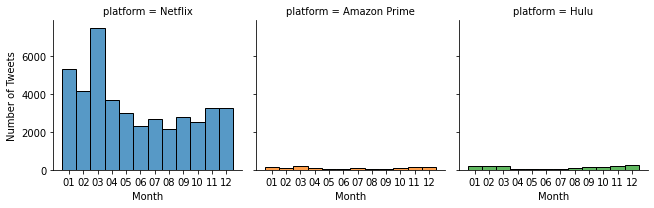

In [21]:
# Number of World Tweets in 2020 by Month and Platform
y=w.sort_values('month', ascending=True)
d = sea.FacetGrid(y, col='platform', hue='platform')
d.map(sea.histplot, 'month').set(xlabel='Month', ylabel='Number of Tweets')

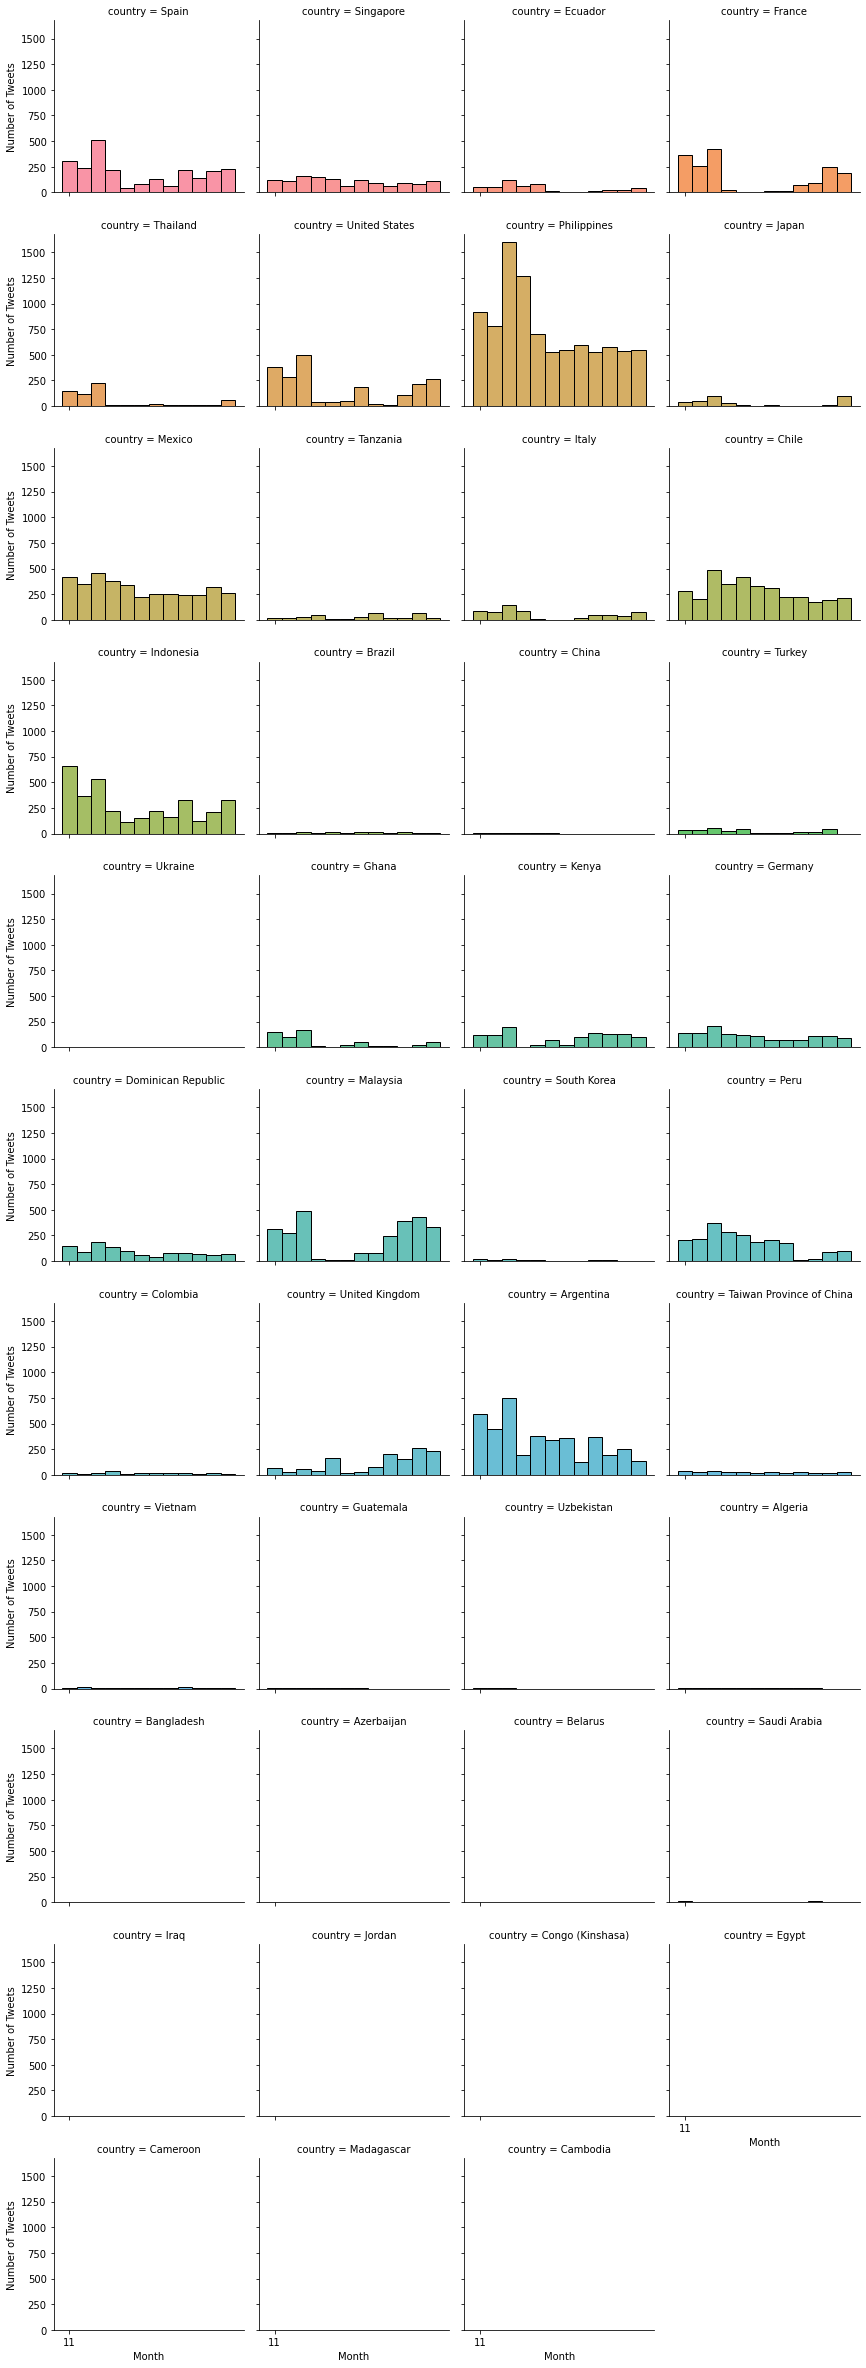

In [22]:
# Number of Tweets in 2020 by Country by Month
y=w.sort_values('month', ascending=True)
e = sea.FacetGrid(y, col='country', col_wrap=4, hue='country')
e.map(sea.histplot, 'month').set(xlabel='Month', ylabel='Number of Tweets')

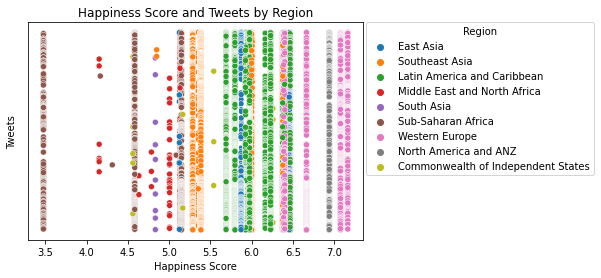

In [50]:
# Join world tweets (all platforms) and happiness rating by country - NEED TO FIX Y AXIS
wtw = world_tweets_all_platforms_df
top50 = top50_happiness_capitals_clean_df

z=wtw.merge(top50, on='country', how='left')
z['All Platforms'] = 'All Platforms'
#z.head()

f = sea.scatterplot(data=z, x="Ladder score", y="id_x", hue='Regional indicator')
f.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0).set_title('Region') # move legend outside plot
f.set(xlabel='Happiness Score', ylabel='Tweets', title='Happiness Score and Tweets by Region')
f.set(yticklabels=[])
f.tick_params(left=False)
f

### ANALYSIS #2 US Demographic Trends on Tweets of Streaming Platforms

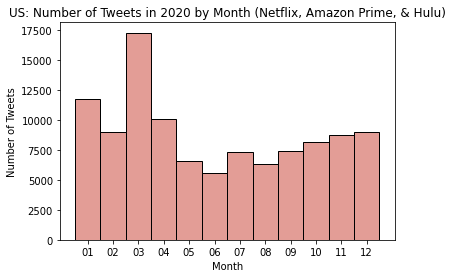

In [25]:
# Number of US Tweets in 2020 by Month
u = us_tweets_all_platforms_df
u['month'] = u['date'].dt.strftime('%m')
v=u.sort_values('month', ascending=True)
g = sea.histplot(v, x='month', color='#da7c73').set(xlabel='Month', ylabel='Number of Tweets', title='US: Number of Tweets in 2020 by Month (Netflix, Amazon Prime, & Hulu)')

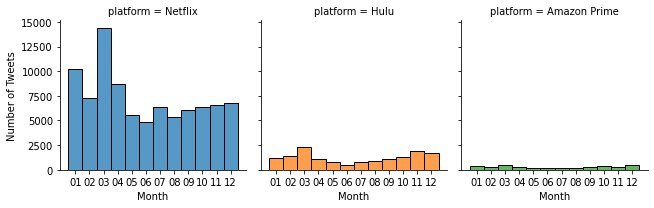

In [26]:
# Number of US Tweets in 2020 by Month and Platform
u=u.sort_values('month', ascending=True)
h = sea.FacetGrid(u, col='platform', hue='platform')
h.map(sea.histplot, 'month').set(xlabel='Month', ylabel='Number of Tweets')

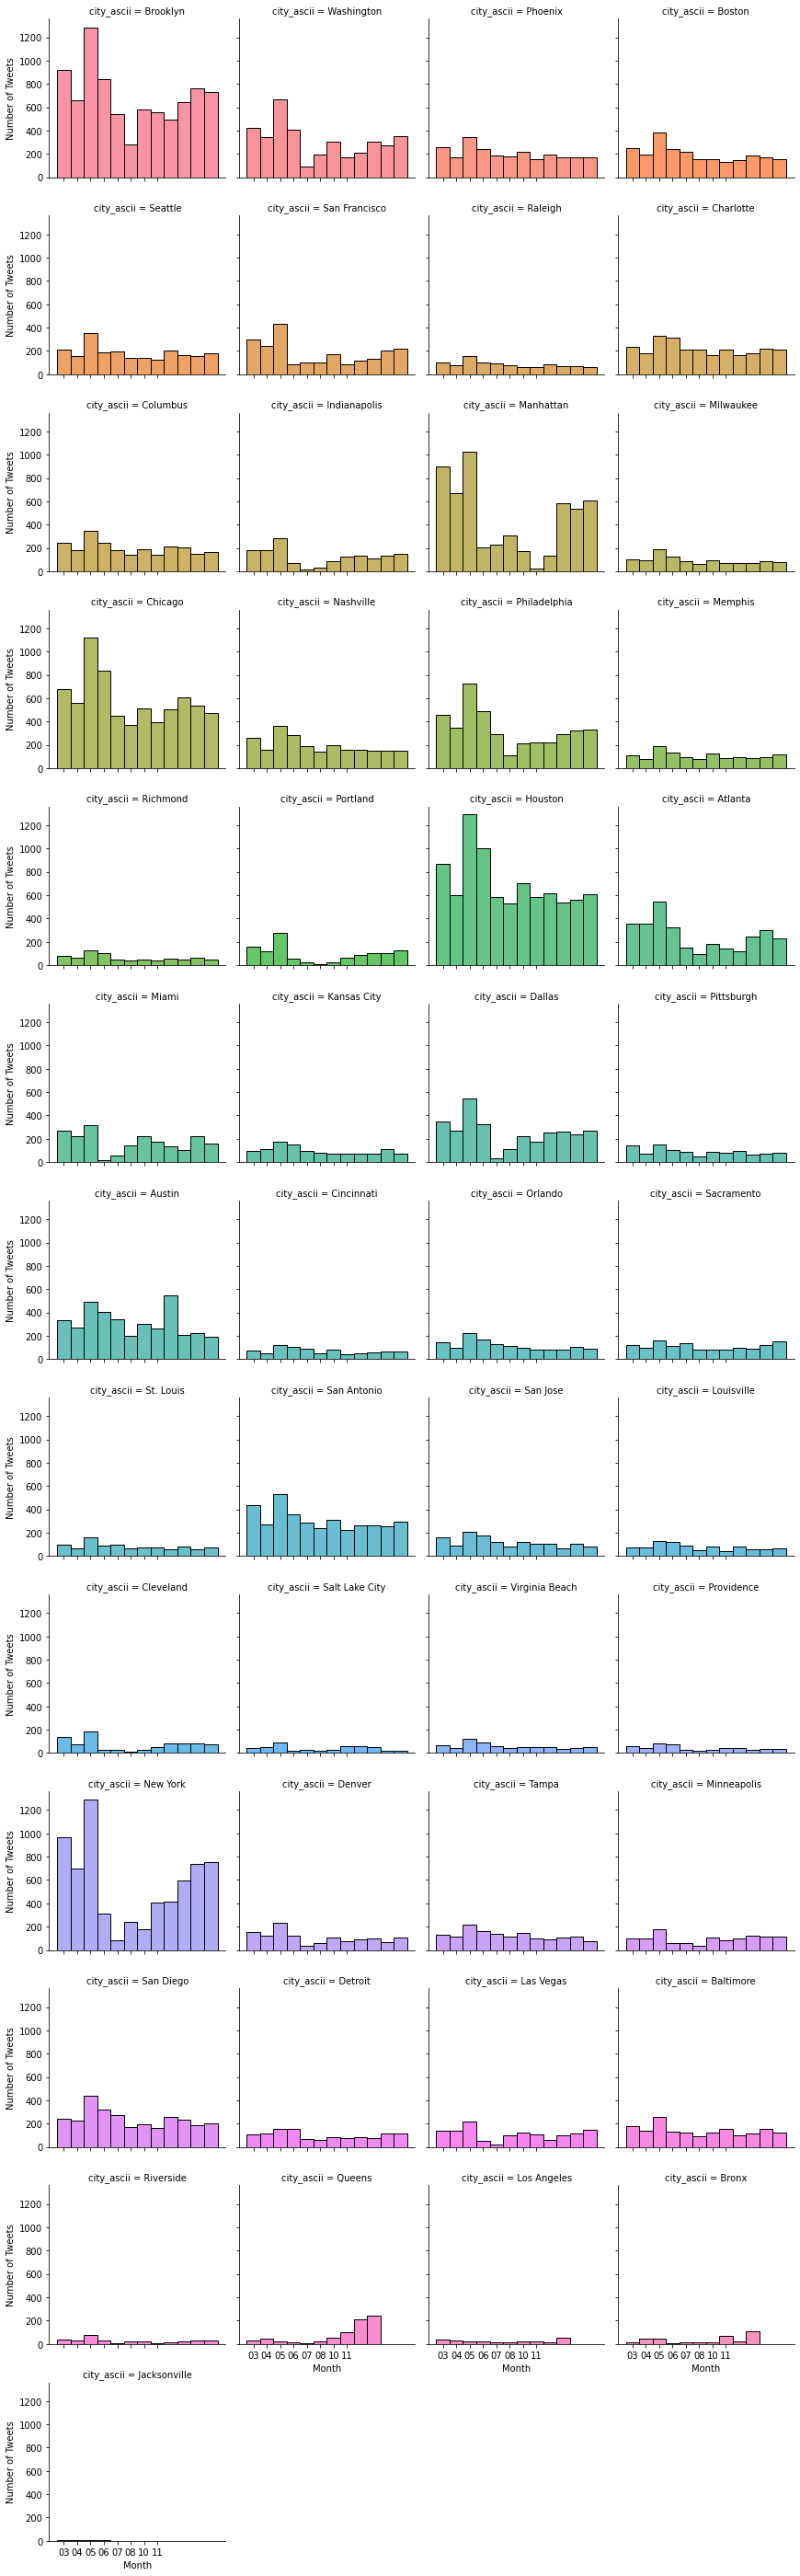

In [27]:
# Number of Tweets in 2020 by US Cities by Month
t=u.sort_values('month', ascending=True)
i = sea.FacetGrid(t, col='city_ascii', col_wrap=4, hue='city_ascii')
i.map(sea.histplot, 'month').set(xlabel='Month', ylabel='Number of Tweets')

### ANALYSIS #3: World correlation analysis on Happiness Report and Twitter data

In [28]:
################################################################################
# ANALYSIS #3: World correlation analysis on Happiness Report and Twitter data #
################################################################################

# Summarize the world_tweets_all_platforms_df dataframe
# Create a new dataframe for worlds tweets and select only the columns we care about from the tweet data
print('Column Names of world_tweets_all_platforms_df: ', world_tweets_all_platforms_df.columns)

world_tweets_select_cols_df = world_tweets_all_platforms_df[['platform', 'city_ascii', 'date', 'likes_count', 'retweets_count', 'replies_count', 'tweet']]
print('World Tweets (Selected Columns) Dataframe Created: \n', world_tweets_select_cols_df.head(10), '\n')

# Expand the platform column into 3 columns that are either 0 or 1 for if the tweet mentioned one of the 3 streaming platforms
world_tweets_select_cols_df = pd.get_dummies(world_tweets_select_cols_df, prefix = 'platform', columns=['platform'])
print('Expanded platform Column into 3 with get_dummies(): \n', world_tweets_select_cols_df.head(10), '\n')

# Perform a Group By on the dataframe by the city_ascii column
world_tweets_group_by_capital_df = world_tweets_select_cols_df.groupby(by=['city_ascii']).sum().reset_index()
print('First 50 Rows World Tweets Dataframe Grouped By Capital Cities: \n', world_tweets_group_by_capital_df.head(50), '\n')
print('World Tweets Dataframe Grouped By Capital Cities Shape: \n', world_tweets_group_by_capital_df.shape, '\n')

# Scale down the top50_happiness_capitals_clean_df for only the columns we need for this analysis
top50_happiness_capitals_select_cols_df = top50_happiness_capitals_clean_df[['city_ascii', 'Country name', 'Ladder score', 'population', 'Logged GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]
print('Happiness Report (Selected Columns) Dataframe Created: \n', top50_happiness_capitals_select_cols_df.head(10), '\n')
print('Happiness Report (Selected Columns) Dataframe Shape: \n', top50_happiness_capitals_select_cols_df.shape, '\n')

# Join top50_happiness_capitals_select_cols_df with world_tweets_group_by_capital_df on the 'city_ascii' column 
# Use a left join because some capital cities had 0 tweets 
world_tweets_and_happiness_joined_df = top50_happiness_capitals_select_cols_df.merge(world_tweets_group_by_capital_df, on='city_ascii', how = 'left')
print('Joined World Tweets and Happiness data together on city_ascii column: \n', world_tweets_and_happiness_joined_df.head(10), '\n')
print('Joined Dataframe Shape: \n', world_tweets_and_happiness_joined_df.shape, '\n')

# Run the correlation analysis 
corr_analysis_df = world_tweets_and_happiness_joined_df.corr(method='pearson')
print('Correlation Analysis Results: \n', corr_analysis_df, '\n')
corr_analysis_df


Column Names of world_tweets_all_platforms_df:  Index(['platform', 'id', 'conversation_id', 'created_at', 'date', 'time',
       'timezone', 'user_id', 'username', 'name', 'place', 'tweet', 'language',
       'mentions', 'urls', 'photos', 'replies_count', 'retweets_count',
       'likes_count', 'hashtags', 'cashtags', 'link', 'retweet', 'quote_url',
       'video', 'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest', 'city_ascii', 'country', 'month'],
      dtype='object')
World Tweets (Selected Columns) Dataframe Created: 
   platform  ...                                              tweet
0  Netflix  ...  この前のステイが最高すぎて南品川の通称「おばあちゃん家ホテル」ことbamba hotelに結...
1  Netflix  ...  てか、ごくせん THE MOVIE Netflixで見終わったけど めっちゃ感動した😭  青...
2  Netflix  ...  大掃除も無事終わりまして…。 Netflixで孤独のグルメ観ながらプチ年忘れの会。  htt...
3  Netflix  ...              緊急取調室Netflixで来たからシーズン1から見てる！杉咲花ちゃん若い！
4  Netflix  ...             

,Ladder score,population,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,likes_count,retweets_count,replies_count,platform_Amazon Prime,platform_Hulu,platform_Netflix
Ladder score,1.000000,0.092946,0.754602,0.826611,0.745345,0.525630,0.029104,-0.350129,0.294066,0.200077,0.264444,0.536595,-0.008961,0.306943
population,0.092946,1.000000,0.212646,0.062889,0.219841,0.178426,0.071970,0.062203,0.355075,0.403031,0.408425,0.145704,0.194133,0.368849
Logged GDP per capita,0.754602,0.212646,1.000000,0.736044,0.865481,0.209105,-0.132002,-0.400931,0.119219,0.094971,0.128693,0.427974,0.162868,0.149955
Social support,0.826611,0.062889,0.736044,1.000000,0.749022,0.439606,-0.093064,-0.342934,0.190180,0.167036,0.180875,0.454370,0.005182,0.234979
Healthy life expectancy,0.745345,0.219841,0.865481,0.749022,1.000000,0.303234,-0.154759,-0.432570,0.067052,0.028924,0.058391,0.483570,0.051160,0.099840
Freedom to make life choices,0.525630,0.178426,0.209105,0.439606,0.303234,1.000000,0.248565,-0.293139,0.234147,0.318657,0.243545,0.082766,0.171368,0.265616
Generosity,0.029104,0.071970,-0.132002,-0.093064,-0.154759,0.248565,1.000000,-0.083421,0.101371,0.245632,0.297384,0.070037,0.273498,0.058503
Perceptions of corruption,-0.350129,0.062203,-0.400931,-0.342934,-0.432570,-0.293139,-0.083421,1.000000,0.010957,0.144513,0.142551,-0.193060,0.126406,0.051856
likes_count,0.294066,0.355075,0.119219,0.190180,0.067052,0.234147,0.101371,0.010957,1.000000,0.835555,0.855276,0.345354,0.112015,0.956166
retweets_count,0.200077,0.403031,0.094971,0.167036,0.028924,0.318657,0.245632,0.144513,0.835555,1.000000,0.707665,0.153304,0.343367,0.837978


### ANALYSIS #4: US text keyword analysis on Twitter data

In [29]:
#########################################################
# ANALYSIS #4: US text keyword analysis on Twitter data #
#########################################################

# Install punkt and stopwords
nltk.download('punkt')
nltk.download('stopwords')

# Convert the tweets from dataframe into a list of tweets
us_tweets_list = []
for index, row in us_tweets_all_platforms_df.iterrows():
	us_tweets_list.append(row['tweet'])

print('Length of us_tweets_list: ', len(us_tweets_list), '\n')

# Store all tokens from each tweet in us_tweets_list
tokens = [tok for tweet in us_tweets_list for tok in nltk.word_tokenize(tweet.lower())]
print('Tokens Count: ', len(tokens), '\n')
print('First 30 Tokens: ', tokens[:30], '\n')

# Import in a list of english stopwords from nltk
stopwords = nltk.corpus.stopwords.words('english')

# Append netflix, primevideo, prime, and hulu to the stopwords list
# We didn't append "video" as a term to the stopwords list since it might be used in other contexts outside of "prime video" as two words
stopwords.extend(['netflix', 'primevideo', 'prime', 'hulu','https',"n't",'shit'])
print('Length of Stopwords List: ', len(stopwords), '\n')

# Create a function to check if a word is all nonalpha characters OR in the stopwords list
def filter_regex_and_stopwords(word, regex_string, stopwords_list):
	regex = re.compile(regex_string)
	if (regex.match(word)) and (word not in stopwords_list):
		return True
	else:
		return False

# Filter out stopwords and words with all nonalphabetic characters
tokens_filtered = [] 
for tok in tokens:
	if filter_regex_and_stopwords(tok, '[A-Za-z]', stopwords):
		tokens_filtered.append(tok)


# Create a freq distribution for the tokens
tokens_freq_dist = nltk.FreqDist(tokens_filtered)
top50_tokens = tokens_freq_dist.most_common(50)
print('Top 50 Tokens: \n', top50_tokens, '\n')

# Create a dataframe for the Top 50 Tokens
top50_tokens_df = pd.DataFrame(top50_tokens, columns = ['token', 'frequency'])
print('First 20 Rows of Top 50 Tokens Dataframe:\n', top50_tokens_df.head(20), '\n')

top50_tokens_df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Length of us_tweets_list:  107293 

Tokens Count:  2486582 

First 30 Tokens:  ['oh', 'at', 'dinner', ':', '@', 'netflix', 'should', 'have', 'a', 'dog', 'mode', 'that', 'auto', 'mutes', 'doorbells', ',', 'knocks', ',', 'and', 'barks', 'so', 'your', 'dog', 'doesn', '’', 't', 'go', 'crazy', 'while', 'you'] 

Length of Stopwords List:  186 

Top 50 Tokens: 
 [('watch', 13496), ('watching', 11847), ('show', 8494), ('good', 7576), ('like', 6799), ('amp', 5991), ('movie', 5670), ('season', 5427), ('new', 5128), ('one', 5110), ('need', 4273), ('watched', 4250), ('series', 4215), ('get', 4186), ('love', 4013), ('time', 3943), ('got', 3890), ('really', 3551), ('know', 3158), ('shows', 2940), ('see', 2774), ('episode', 2759), ('go', 2614), ('still', 2558), ('back', 2531), ('movies',

,token,frequency
0,watch,13496
1,watching,11847
2,show,8494
3,good,7576
4,like,6799
5,amp,5991
6,movie,5670
7,season,5427
8,new,5128
9,one,5110


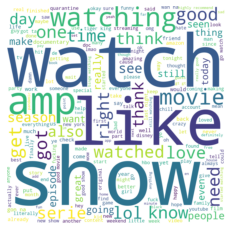

In [30]:
# Wordcloud!  What were people tweeting about...

# Convert the filtered tokens list to string using list comprehension 
listToStr = ' '.join(map(str, tokens_filtered)) 
wordcloud = WordCloud(width = 1600, height = 1600, 
                background_color ='white', 
                stopwords = stopwords, max_words=200,
                min_font_size = 10).generate(listToStr)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()